In [1]:
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, IsolationForest, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold



import os
for dirname, _, filenames in os.walk('/kaggle/input/titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train =  pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

#### Printing the value counts for the train set

In [24]:
complete

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0.0,3,male,22.000000,1,0,7.2500,S
2,1.0,1,female,38.000000,1,0,71.2833,C
3,1.0,3,female,26.000000,0,0,7.9250,S
4,1.0,1,female,35.000000,1,0,53.1000,S
5,0.0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
1305,NaN,3,male,29.881138,0,0,8.0500,S
1306,NaN,1,female,39.000000,0,0,108.9000,C
1307,NaN,3,male,38.500000,0,0,7.2500,S


In [3]:
for i in train.columns:
    print(train[i].value_counts())

1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: PassengerId, Length: 891, dtype: int64
0    549
1    342
Name: Survived, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtyp

#### Joining the train and test data set

In [4]:
complete = pd.concat([train, test])

#### Checking for null and duplicated values

In [5]:
complete.duplicated().sum()
complete.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

#### Replacing the null values for Age and Fare with mean and null values for Embarked with mode.


In [6]:
complete['Age'] = complete['Age'].fillna(np.mean(complete.Age))
complete['Fare'] = complete['Fare'].fillna(np.mean(complete.Fare))
complete['Embarked'] = complete['Embarked'].fillna(complete.Embarked.mode()[0])
complete.drop(columns = ['Cabin', 'Name', 'Ticket'], inplace = True)
complete.set_index('PassengerId',inplace = True)

In [7]:
train = complete[complete.Survived.notnull()]
test = complete[complete.Survived.isnull()]

In [8]:
train.reset_index(inplace = True)
train.drop(columns = 'PassengerId', inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Separating the predictors and traget variable

In [9]:
y = train.Survived
train = train.drop(columns = 'Survived')


#### Checking the distribution of the target variable

<AxesSubplot:xlabel='Survived', ylabel='count'>

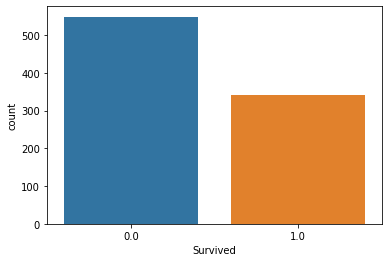

In [10]:
sns.countplot(x=y)

#### Checking the distribution of categorical predictor variables

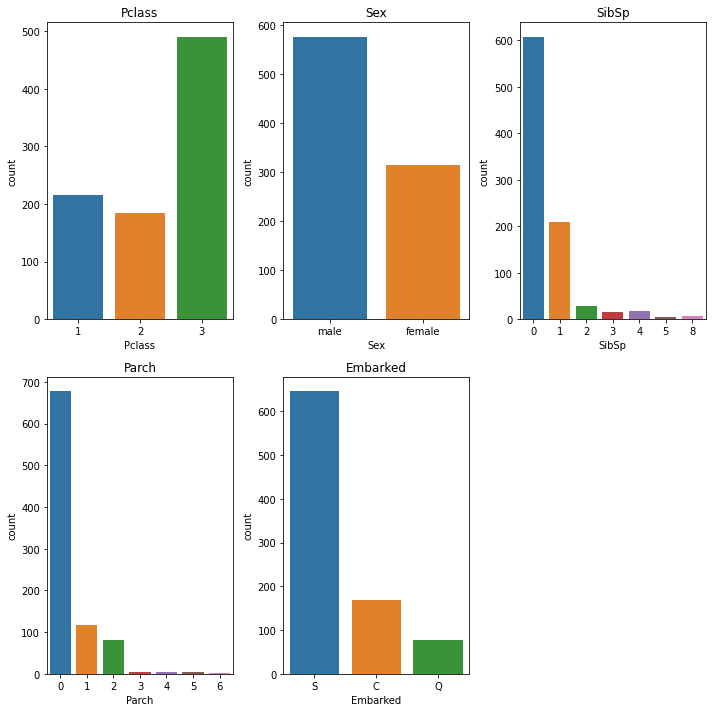

In [11]:
fig, axes = plt.subplots(nrows=2, ncols = 3, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    if i< len(['Pclass', 'Sex', 'SibSp', 'Parch',
       'Embarked']):
        sns.countplot(x= train[(['Pclass', 'Sex', 'SibSp', 'Parch',
       'Embarked'][i])], ax= ax)
        ax.set_title(['Pclass', 'Sex', 'SibSp', 'Parch',
       'Embarked'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

#### Checking the distribution of continuous predictor variables

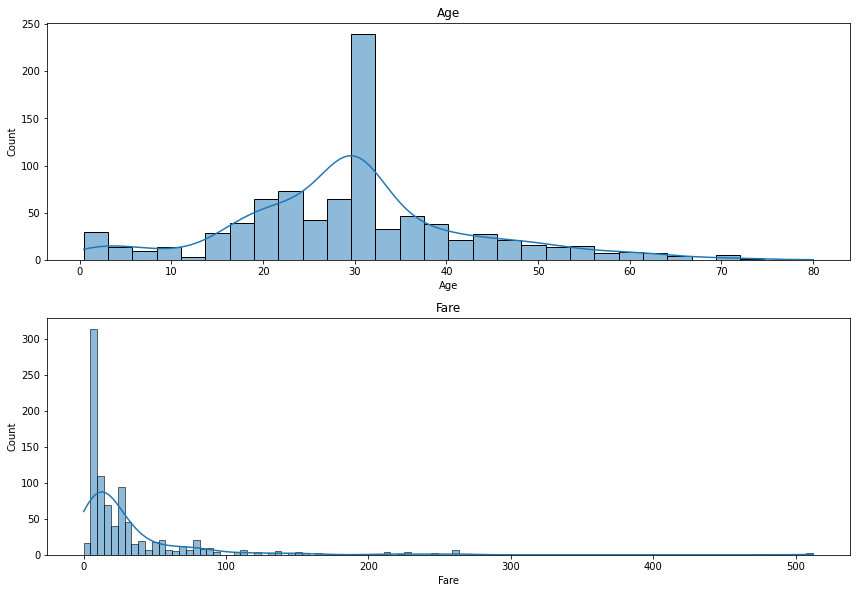

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    if i < len(['Age', 'Fare']):
        sns.histplot(train[(['Age', 'Fare'][i])], kde=True, ax=ax)
        ax.set_title(['Age', 'Fare'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

#### One hot encoding

In [13]:
train = pd.get_dummies(train)

#### Defining a function model_eval which uses RandomizedSearchCV for parameter tuning 
* Nested cross val used for training and testing to reduce the bias.
* tqdm used to display a progress bar when performing parameter tuning.
* Storing the score during each iteration and printing the mean score. 

In [14]:
def model_eval(model, param, train, y):
    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    random = RandomizedSearchCV(model, param, scoring = 'accuracy', n_jobs = -1, cv = inner_cv, random_state = 0)
    scores = []
    n_iter = random.n_iter
    with tqdm(total = n_iter) as pbar:
        for i in range(n_iter):
            random.set_params(n_iter = 1)
            for train_index, test_index in outer_cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                random.fit(trainx, trainy)
                scores.append(random.best_estimator_.score(testx, testy))
            pbar.update()
    print(random.best_params_)
    print('Average score', np.mean(scores))
    

### Decision Tree used for predictions
Mean accuracy of 80.1% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier

In [15]:
model = DecisionTreeClassifier()
min_samples_split = np.array(range(1, 100))
max_depth= np.array(range(1,100))
criterion = ['entropy', 'gini', 'log_loss']
param = {'min_samples_split': min_samples_split, 'max_depth' : max_depth, 'criterion' : criterion}
model_eval(model, param, train, y)


100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

{'min_samples_split': 60, 'max_depth': 28, 'criterion': 'entropy'}
Average score 0.8006879668570711


### Random Forest used for predcitions
Mean accuracy of 81.2% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier
* n_estimators- no. of trees in the forest

In [16]:
model = RandomForestClassifier()
min_samples_split = np.array(range(1, 100))
max_depth = np.array(range(1, 100))
criterion = ['gini', 'entropy']
n_estimators = np.array(range(100, 400, 5))
param = {'min_samples_split': min_samples_split, 'max_depth': max_depth, 'criterion': criterion, 'n_estimators': n_estimators}
model_eval(model, param, train, y)

100%|██████████| 10/10 [00:39<00:00,  3.95s/it]

{'n_estimators': 155, 'min_samples_split': 47, 'max_depth': 52, 'criterion': 'gini'}
Average score 0.811894419684891


### Extra Trees used for predcitions
Mean accuracy of 79.6% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier
* n_estimators- no. of trees in the forest

In [17]:
model = ExtraTreesClassifier()
criterion = ['gini', 'entropy']
max_depth = np.array(range(50, 150))
min_samples_split = np.array(range(1, 100))
n_estimators = np.array(range(100,300, 2))
param = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'n_estimators': n_estimators}
model_eval(model, param, train, y)


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]

{'n_estimators': 122, 'min_samples_split': 88, 'max_depth': 80, 'criterion': 'gini'}
Average score 0.7957202937668696


### GaussianNB used for prediction
Mean accuracy of 78.3% obtained in the test set.

Parameters tuned:
* var_smoothing- Adds a value to the variance of the distribution of the train set

In [18]:
model = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9, num=100)}
model_eval(model, param, train, y)

100%|██████████| 10/10 [00:02<00:00,  4.79it/s]

{'var_smoothing': 0.0001}
Average score 0.7833469336513715


### SVC used for prediction
Mean accuracy of 78.7% obtained in the test set.

Parameters tuned:
* C- Regularization parameter. The strength of the regularization is inversely propotional to C
* gamma- control the shape of the decision boundary.Larger value implies overfitting.
* kernel- poly, linear and rbf are selected  

In [19]:
model = SVC()
param = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100],'kernel': ['rbf', 'poly', 'linear'] }
model_eval(model, param, train,y)

100%|██████████| 10/10 [00:35<00:00,  3.53s/it]

{'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}
Average score 0.7867553825874082


### Bagging Classifier used for prediction
Mean accuracy of 83.3% obtained in the test set.

Parameters tuned:
* n_estimators- no. of estimators
* max_features- max no. of features 

In [20]:
model = BaggingClassifier()
n_estimators = np.array(range(100,300,2))
max_features = np.array(range(1,20))
param = {'n_estimators': n_estimators, 'max_features': max_features}
model_eval(model, param, train, y)

100%|██████████| 10/10 [01:28<00:00,  8.80s/it]

{'n_estimators': 268, 'max_features': 7}
Average score 0.8328585776159688


### XGBoost used for prediction
Mean accuracy of 81.3% obtained in the test set.


In [21]:
model = XGBClassifier(objective='binary:logistic',
                     eval_metric='error')
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                scores.append(model.score(testx, testy))
print('Average score', np.mean(scores))

Average score 0.8125290314481199


### LGBM Boost used for prediction
Mean accuracy of 82.3% obtained in the test set.

Parameters tuned:
* leatning_rate- learning rate of the model
* max_depth- max_depth of the tree
* alpha- l1 regularization
* reg_lambda- l2 regularization
* colsample_bytree- subsample ratio of columns when constructing each tree
* subsample- subsample ratio
* subsample_freq- frequency of the subsample
* min_child_samples- min no. of data needed in a child(leaf)
* n_estimators- no. of trees
* num_leaves- max tree leaves

In [22]:
model = LGBMClassifier()
learning_rate = np.linspace(0.01, 0.2, 10)
max_depth = np.array(range(1, 10))
alpha= np.array(range(0, 50))
reg_lambda = np.linspace(0, 100, 10)
colsample_bytree = np.linspace(0.1,1, 10)
subsample = np.linspace(0.1, 1, 10)
subsample_freq = np.array(range(1, 10, 10))
min_child_samples  = np.array(range(1,50,10))
n_estimators = np.array(range(200, 2000,100 ))
num_leaves =np.array(range(2, 200, 11))
param= {'learning_rate': learning_rate, 'max_depth': max_depth, 'alpha': alpha, 'reg_lambda': reg_lambda, 'colsample_bytree': colsample_bytree,
        'subsample': subsample, 'subsample_freq': subsample_freq, 'min_child_samples': min_child_samples, 'n_estimators': n_estimators,
        'num_leaves': num_leaves}
model_eval(model, param, train, y)

100%|██████████| 10/10 [01:07<00:00,  6.77s/it]

{'subsample_freq': 1, 'subsample': 1.0, 'reg_lambda': 33.33333333333333, 'num_leaves': 68, 'n_estimators': 1800, 'min_child_samples': 21, 'max_depth': 4, 'learning_rate': 0.1366666666666667, 'colsample_bytree': 0.5, 'alpha': 17}
Average score 0.8226476680685457


### Cat Boost used for prediction
Mean accuracy of 83.4% obtained in the test set.

In [23]:
model = CatBoostClassifier(verbose = 0)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                scores.append(model.score(testx, testy))
print('Average score', np.mean(scores))


Average score 0.8338773460548616
